# GeoNewsMiner - Geocoding *ChroniclItaly*

This [Jupyter notebook](https://jupyter.org/) implements the data processing and geocoding for the GeoNewsMiner (GNM) project. GNM is an interactive tool that maps and visualises geographical references in historical newspapers. As a use case, we used Italian immigrant newspapers published in the United States from 1898 to 1920, as collected in the corpus [*ChroniclItaly*](https://public.yoda.uu.nl/i-lab/UU01/T4YMOW.html) (Viola 2018). The corpus was previously tagged for entities using a sequence tagging tool ([Riedl and Padó 2018](https://www.aclweb.org/anthology/P18-2020.pdf)). This tagged version of *ChroniclItaly* is [*ChroniclItaly 2.0*](https://public.yoda.uu.nl/i-lab/UU01/4MECRO.html) and it is available as an open access resource. The overarching goal of this project is to offer new perspectives on the geographies of the past. Methodologically, we extracted from the corpus the references to place names, quantified them, geo-coded them, and plotted them on a map. 

Please read the [README](https://github.com/lorellav/GeoNewsMiner) for more information and context on this project.

## Table of Contents

1. [Environment set-up](#Environment-set-up)
2. [Data pre-processing](#Data-pre-processing)
3. [Geocoding](#Geocoding)
4. [Fixing geocoding errors](#Fixing-geocoding-errors)

## Environment set-up

The code in this notebook is written in Python 3. If you are new to Python, please install Anaconda from https://www.anaconda.com/distribution/. The list of dependencies required to run this notebook correctly can be found in [requirements.txt](https://github.com/lorellav/GeoNewsMiner/blob/master/requirements.txt). The dependencies can be installed with [Anaconda Navigator](https://docs.anaconda.com/anaconda/navigator/) or with the command `pip install -r requirements.txt` from the command line (CMD.exe or terminal).

In [1]:
%matplotlib inline

# internal dependencies
import glob
import os
import sys
import datetime as dt
from pathlib import Path
from pprint import pprint

# external depencies
from tqdm import tqdm
import pandas as pd

### Folders, variables and settings

First, we initialise the structure of our repository. Executing the next cell sets the definitions to the folders and files in the project. We use the `/output` folder for all files generated during the execution of this notebook. All results are reproducible. The `/data` folder is used for all static, non-changing files. 

In [2]:
# location of the data folder and files
data_folder = "data"

fp_metadata = os.path.join(data_folder, 'ChroniclItaly_title_lccn.csv')

# location of the output folder and files
output_folder = "output"

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

fp_stats = os.path.join(output_folder, 'ChroniclItaly_stats_per_doc.csv')

## Data pre-processing

GNM extracts the geographical entities from *ChroniclItaly* as they were found using an advanced machine-learning tool, [sequence tagging](https://github.com/riedlma/sequence_tagging#download-models-and-embeddings) (Riedl and Padó 2018) that implements [Tensorflow](https://www.tensorflow.org/). In this step, geographical locations are extracted from the tagged results. For more information on the sequence tagging, please refer to the [README](https://github.com/lorellav/GeoNewsMiner#sequence-tagging). 

The data output by the tagger has the format as found below. The first column is the input word, the second column specifies the pre-processed, lower-cased word, the third column contains a flag, whether the word has been known during training (KNOWN) or not (UNKNOWN). If labels are assigned to the input file, these will appear in the third column. The last column contains the predicted tags. The no-entity tag is `O`. Because some entities (like Stati Uniti) have multiple words, the tagging scheme distinguishes between the beginning (tag `B-...`) or the inside of an entity (tag `I-...`). Locations can be tagged with `LOC` of `GPE`. 

```sh
il         il         KNOWN   O       O
principio  principio  KNOWN   O       O
delle      delle      KNOWN   O       O
ostilità   ostilità   KNOWN   O       O
fra        fra        KNOWN   O       O
la         la         KNOWN   O       O
Spagna     spagna     KNOWN   O       B-GPE
e          e          KNOWN   O       O
gli        gli        KNOWN   O       O
Stati      stati      KNOWN   O       B-GPE
Uniti      uniti      KNOWN   O       I-GPE
.          .          KNOWN   O       O
```

The next cell implements the functions used to group the tags with multiple words. The function `combine_tags()` accepts a list with pairs with the word and the tag, such as: `[("spagna", "B-GPE"), ("e", ""), ("gli", ""), ("stata", "B-GPE"), ("uniti", "I-GPE"), (".", "")]`

In [3]:
# This defines the function to combine tags that start with a B tag and 
# are followed by I tags. 

def _endswidth_list(s, list_s_end):
    """Check if string ends with a value in the list"""
    for s_end in list_s_end:
        if s and s.endswith(s_end):
            return True
    return False

def combine_tags(words_with_tags, tags=["LOC", "GPE"]):
    """Combine tags is they consist of multiple words"""
    results = []
    
    for token, label in words_with_tags:
              
        # continue if label is not in the list
        if not _endswidth_list(label, tags):        
            continue
            
        # split the document in a prefix (I or B) and a tag
        prefix, tag = label.split("-")
        
        # if I, append to previous
        if prefix == "I":
            try: 
                results[-1] = (results[-1][0] + " " + token, results[-1][1])
            except IndexError:
                pass
        else:
            results.append((token, tag))
    
    return results

### File by file processing

Each file in *ChroniclItaly* has a structured name: `2012271201_1903-08-08_ed-1_seq-1_ocr.txt`, `2012271201_1903-08-15_ed-1_seq-1_ocr.txt`, `2012271201_1903-08-22_ed-1_seq-1_ocr.txt`. 

The first part of the file name is the LCCN identifier (in this case 2012271201) of each newspaper's title. The second part of the file name contains the date of publication (for example '1903-06-06'). The rest of the metadata in the file name is not relevant for this analysis and is ignored. 

In [4]:
# read the meta data with the Titles of the papers
meta_data = pd.read_csv(fp_metadata)
meta_data['LCCN'] = meta_data['LCCN'].str.replace(' ', '')  # remove space in sn numbers
meta_data

,Title,LCCN
0,La sentinella del West Virginia,sn86092310
1,L'Italia,sn85066408
2,"Cronaca sovversiva. (Barre, Vt.)",2012271201
3,La libera parola,sn85055164
4,The patriot,sn85054967
5,La ragione,sn84037024
6,La rassegna,sn84037025


The files in *ChroniclItaly 2.0* have the format as described in Section [Data-pre-processing](#Data-pre-processing). The tags `LOC` and `GPE`, relevant for the analysis, are combined and counted. The column `location` stores all the entities tagged as location`LOC`, the column `freq` shows the corresponding frequency of occurrence, the column `word_count` contains a count of the words in the file. All other columns are repeated metadata from the file name. 

For example, the output of the file `2012271201_1903-08-15_ed-1_seq-1_ocr.txt` is shown below. The location "amsterdam" was mentioned once in the document and "australia" was mentioned 3 times. Moreover, the document contains 1,695 words. 

|        LCCN | Title                            | date                |   year | location   |   freq |   word_count | loc/gpe   | filename                                 |
| -----------:|:---------------------------------|:--------------------|-------:|:-----------|-------:|-------------:|:----------|:-----------------------------------------|
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | amsterdam  |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | australia  |      3 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | belgio     |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | bruxelles  |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | ispagna    |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | italia     |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | melbourne  |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | olanda     |      2 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | parma      |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | rima       |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |
|  2012271201 | Cronaca sovversiva. (Barre, Vt.) | 1903-08-15 00:00:00 |   1903 | torino     |      1 |         1695 | GPE       | 2012271201_1903-08-15_ed-1_seq-1_ocr.txt |

The following code iterates over all files and generates data frames like the one above. All the data frames are then combined in `df_locations`. 

In [ ]:
# construct a generator on input files
input_files = Path(data_folder).glob(str(Path("**","*.txt")))

results = []

# reading the raw_data files: iterate over all txt files in ./data directory
for index, data_fp in tqdm(enumerate(input_files)):
    
    # extract sn number and date from the filename
    sn, raw_date, _, _, _ = str(data_fp.stem).split('_')
    
    # read the ocr file into pandas dataframe
    df_data = pd.read_csv(
        data_fp, 
        sep='\t', 
        names=['token', 'token_lowercase', 'col2', 'col3', 'tag', 'col5']
    )
    
    # combine the tokens
    location_tag_tuples = combine_tags(
        [tuple(x) for x in df_data[['token', 'tag']].values],
        tags=["LOC", "GPE"]
    )
    
    df_location_tag = pd.DataFrame(location_tag_tuples, columns=['location', 'loc/gpe'])
    
    # some cleaning and preprocessing 
    df_location_tag['location'] = df_location_tag['location'].str.lower()
    df_location_tag['location'] = df_location_tag['location'] \
        .str.normalize('NFKD') \
        .str.encode('ascii', errors='ignore') \
        .str.decode('utf-8') \
        .str.replace(r"[^a-z\'\"\-\s]", "") \
        .str.strip()
    
    # group and count the tokens
    df_location_tag_count = df_location_tag \
        .groupby(['location', 'loc/gpe']) \
        .size() \
        .rename("freq") \
        .reset_index()
            
    # merge gpes and locs and add additional data
    df_location_tag_count['LCCN'] = sn
    df_location_tag_count['filename'] = str(data_fp).split('/')[-1]
    df_location_tag_count['date'] = raw_date
    df_location_tag_count['date'] = pd.to_datetime(df_location_tag_count['date'])
    df_location_tag_count['year'] = df_location_tag_count['date'].dt.year
        
    # merge meta data
    df_location_tag_count = df_location_tag_count.merge(meta_data, on="LCCN", how="left")
    
    # compute the number of words in the document
    df_location_tag_count['word_count'] = df_data['token'].str.match(r'\w+').sum()
    
    # append df to results
    results.append(df_location_tag_count)

df_locations = pd.concat(results) 

# column order and sorting 
df_locations = df_locations[['LCCN', 'Title', 'date', 'year', 'location', 'freq', 'word_count', 'loc/gpe', 'filename']]
df_locations.sort_values(by='date', inplace=True)

Results are loaded in `ChroniclItaly_stats_per_doc.csv`. 

In [ ]:
# write results to csv file
df_locations.to_csv(fp_stats, index=False)

In [5]:
# read from file (start with the script from this point if file is available)
df_locations = pd.read_csv(fp_stats)

### Results, frequencies and stats

The following is the results of the process of location extraction. The following lines of code allow users to carry out some preliminary explorations of the results such as looking at the top 20 most frequently mentioned locations, the number of unique locations, the total number of geographical references, and so on. 

In [6]:
# the top 20 locations in terms of "document frequency"
df_locations['location'].value_counts().head(20)

italia           3424
roma             3386
new york         2858
stati uniti      2396
francia          2362
parigi           2206
san francisco    2012
londra           1998
russia           1938
washington       1830
america          1826
germania         1822
napoli           1751
milano           1643
genova           1353
inghilterra      1204
europa           1196
pietroburgo      1182
berlino          1173
torino           1126
Name: location, dtype: int64

In [7]:
# the number of unique locations (without cleaning or geocoding)
len(df_locations['location'].unique())

31579

In [8]:
# the number of locations found across all articles
df_locations['freq'].sum()

214110

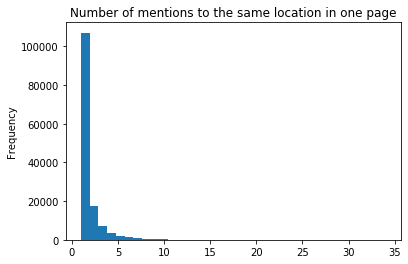

In [9]:
# the number of times the same location in mentioned in the frontpage
fig = df_locations['freq'].plot.hist(
    bins=35,
    title="Number of mentions to the same location in one page"
)

## Geocoding 

In this step, the locations found in the dataset are geocoded. Geocoding provides (standardised) information like a place identifier and WGS84 (World Geodetic System) coordinates. To perform the geocoding, we use the Google Maps Geocoding API. For costs please refer to https://developers.google.com/maps/documentation/geocoding/usage-and-billing. 

In order to perform geocoding, users must have an API key. The API key is a unique identifier, a 40-character long string that is used to authenticate requests associated with a project. To get an API key, visit the [Google Cloud Platform Console](https://cloud.google.com/console/google/maps-apis/overview). 

Geocoding with Google is a two-stage process. First, Google Geocoding API provides users with a Place ID for each location. The Place ID uniquely identifies a place as it is stored in the Google Places database and on Google Maps. Because the language of the dataset is Italian, the language of the API was set to Italian. It was found that setting the API language as the language of the data-set improves the accuracy of the geocoding results. At the same time, however, the results are also returned in Italian. In order to have the results returned in Enlgish, only the Place ID was extracted in this first stage. Once the Place ID was received, it was possible to use the Google Geocoding API to perform *reverse geocoding*, that is to obtain all the details for the location in English (e.g., geo-coordinates, administrative level). In this way, the results are dispalyed in English thus making the GNM App more user-friendly. 

The following example outlines the two-stage process with a simple code example. 
```
x_loc = gc_client.geocode("roma", language="it")
pprint(x_loc)
print()
y_loc = gc_client.reverse_geocode(x_loc[0]['place_id'], language="en")
pprint(y_loc)
```

In addition to the geo-coordinates, Google also provides additional details, such as the tag *type[]*. Understanding the *type[]* of a location is important because it shows why Google has provided given geo-coordinates to a location. Some of these geo-coordinates may have been "misinterpreted" and therefore the field *type[]* should be checked. "Misinterpretations" may happen especially when working with historical data. Because the Google Places database stores places based on a contemporary world map, the locations in a historical dataset may have changed name or may no longer exist. Moreover, categories such as country, city, region, municipality, etc. which Google uses to determine the location *type[]* are highly dependent on the location itself and consequently certain categories may not apply or they may change from place to place. Read more about the *type* [here]:(https://developers.google.com/maps/documentation/geocoding/intro). The most common types in our dataset are given by:

> - **political**: indicates a political entity. Usually, this type indicates a polygon of some civil administration.
- **country**: indicates the national political entity, and it is typically the highest order type returned by the Geocoder.
- **administrative_area_level_1**: indicates a first-order civil entity below the country level. Within the United States, these administrative levels are States. Not all countries have this administrative level. In most cases, administrative_area_level_1 short names will closely match ISO 3166-2 subdivisions and other widely circulated lists; however, this is not guaranteed as our geocoding results are based on a variety of signals and location data.
- **administrative_area_level_2**: indicates a second-order civil entity below the country level. Within the United States, these administrative levels are counties. Not all nations exhibit these administrative levels.
- **colloquial_area**: indicates a commonly-used alternative name for the entity.
- **locality indicates**: indicates an incorporated city or town political entity.
- **sublocality**: indicates a first-order civil entity below a locality. 


### Cost estimation

To avoid incurring in high costs, we estimated the costs as it is shown in the cells below. This can be done by separating the unique locations  from the frequency counts in the aggregated file (`df_locations`). The frequency count is multiplied for the price of 5.00 USD per 1000 requests.

We also noticed that in our dataset, the highest number of incorrectly tagged entities occurred for the least mentioned locations, probably due to OCR mistakes in the original data. Therefore, we performed the geocoding only for the locations that occurred >8 times. 

In [10]:
unique_locations = df_locations['location'].unique()

print("The number of unique locations:", len(unique_locations))
print("Estimated Google geocoding costs:", len(unique_locations)*5/1000)

The number of unique locations: 31579
Estimated Google geocoding costs: 157.895


In [11]:
place_counts = df_locations. \
    groupby('location'). \
    agg({'freq': 'sum', 'Title': 'nunique'}). \
    rename(columns={'freq': 'occurs', 'Title': 'volumes'}). \
    sort_values(["occurs", "volumes"], ascending=False)

selected_locations = place_counts[(place_counts['occurs']>=8)]

print("The number of interesting locations:", len(selected_locations))
print("Estimated Google geocoding costs:", len(selected_locations)*5/1000)

The number of selected locations: 1368
Estimated Google geocoding costs: 6.84


### Initializing Google Maps API

In order to perform the geocoding with Google Maps API, users must have an API key. The API key is a unique identifier, a 40-character long string that is used to authenticate requests associated with a project. To get an API key, visit the [Google Cloud Platform Console](https://cloud.google.com/console/google/maps-apis/overview). The key should be stored in a secure location/file on your device. The following code shows how to request a key. 

In [ ]:
# import the package googlemaps (maintained by Google)
import googlemaps

# set the maximum query rate
gc_rate  = 50

# get the API key from file 
api_key_file = os.path.expanduser(
    os.path.join('~', 'Credentials', 'googlemaps.txt')
)

with open(api_key_file) as f:
    api_key = f.read().strip()

# Initialise the Google Maps client
gc_client = googlemaps.Client(key=api_key, queries_per_second=gc_rate)

To improve the geocoding process, it may be useful to define some functions as shown below. 

In [ ]:
# columns and order of variables to export
export_columns = [
    'location', 'placeid', 'formatted_address', 'location_type', 'continent', 
    'colloquial_area', 'country', 'country_short', 'admin_1', 'admin_2', 'locality', 
    'natural_feature', 'point_of_interest', 'lat', 'lon', 'partial'
]

def get_placeid(string, api_client=gc_client, language=None):
    """Get place id for location string"""
    try:
        place = api_client.geocode(string, language=language)
        try:
            place_id = place[0]['place_id']
        except Exception:
            place_id = None
    except:
        place_id = None
    return place_id


def lookup_placeid(placeid, api_client=gc_client):
    """Retrieve detailed information for placeid"""

    try:
        data = gc_client.reverse_geocode(placeid)
    except:
        return {} # Problem with geocoding API call

    
    result = {
        'formatted_address' : None,
        'location_type' : None,
        'country' : None,
        'country_short' : None,
        'admin_1' : None,
        'admin_2' : None,
        'locality' : None,
        'colloquial_area' : None,
        'continent' : None,
        'natural_feature' : None,
        'point_of_interest' : None,
        'lat' : None,
        'lon' : None,
        'partial' : None,
    }

    try:
        data = data[0]  # first result
        result['formatted_address'] = data['formatted_address']
        result['location_type'] = "+".join(data['types'])
        result['lat'] = data['geometry']['location']['lat']
        result['lon'] = data['geometry']['location']['lng']
        try:
            result['partial'] = result['partial_match']
        except:
            pass
    except:
        print("Problem with geocoding %s" % (placeid))
        return {}
    
    try:
        for address in data['address_components']:
            comp_type = address['types'][0]  # first types
            if comp_type == 'locality':
                result['locality'] = address['long_name']
            if comp_type == 'country':
                result['country'] = address['long_name']
                result['country_short'] = address['short_name']
            if comp_type == 'administrative_area_level_1':
                result['admin_1'] = address['long_name']
            if comp_type == 'administrative_area_level_2':
                result['admin_2'] = address['long_name']
            if comp_type == 'colloquial_area':
                result['colloquial_area'] = address['long_name']
            if comp_type == 'natural_feature':
                result['natural_feature'] = address['long_name']
            if comp_type == 'point_of_interest':
                result['point_of_interest'] = address['long_name']
            if comp_type == 'continent':
                result['continent'] = address['long_name']
    except:
        return {}
    
    return result

In the next cell, the selected locations (with a frequency of at least 8) are queried with the API. The language for the place id extraction is set to 'it' ('italian'). This provides better geocoding results. The `lookup_placeid()` function queries the variables like 'formatted_address', 'location_type', 'continent', 'colloquial_area', 'country', 'country_short', 'admin_1', 'admin_2', 'locality', 'natural_feature', 'point_of_interest', 'lat' and 'lon'. The result of the geocoding is stored in a datetime stamped file in the output folder. 

In [ ]:
# result file with the location-coordinates (datetime coded)
fp_geodata_base = os.path.join(
    output_folder, 
    "output_" +
    dt.datetime.now().strftime("%Y%H%d_%I%M%S") +
    "_geocoding")

geo_codes = []

for loc in tqdm(selected_locations.index):

    result_loc = {"location": loc}

    # get the placeid
    placeid = get_placeid(loc, language="it")
    result_loc["placeid"] = placeid

    # if placeid, lookup geodata
    if placeid:
        geo_code = lookup_placeid(placeid)
        result_loc.update(geo_code)

    geo_codes.append(result_loc)

geo_codes_df = pd.DataFrame(geo_codes).set_index("location")
geo_codes_df = geo_codes_df[export_columns[1:]]
geo_codes_df.to_csv(fp_geodata_base + ".csv")
geo_codes_df.to_excel(fp_geodata_base + ".xlsx")

## Fixing geocoding errors

The geocoding results may contain errors. Errors 
can be the result of mistakes in the geocoding algorithm, the lack of important
information or OCR problems. 
Correcting these errors is necessary to have a valid and clean dataset. These mistakes can be corrected manually 
in the `.xslx` file. To speed up the process, we developed a
function that finds the correct location and copies it 
to the clipboard immediately. 

##### Example

The location 'Zara' is a good example. The geocoding algorithm of Google
identified it as a clothing store in the USA. Given the historical context of the study, this is obviously a mistake. 
The mentions refers to the Province of Zara - today Zadar - in Croatia which used to be a territory of the Kingdom of Italy from 1918 to 1947. 
Therefore, we corrected the location and asked the geocoding
algorithm to geocode Zara as "Zadar Croatia". 

```
> manual_loopup("Zadar Croatia")
```

|location    |   placeid    |  formatted_address  | location  | placeid | formatted_address  |location_type |continent |colloquial_area  |country | admin_1 | admin_2 | locality | natural_feature |  point_of_interest    |    lat    |    lon | partial  |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| zadar croatia  | ChIJj7jA0mL6YUcRhAf0Exw-MhI   | Zadar, Croatia  | locality+political   |   None        |    None  | Croatia  |  None  |  None   | Zadar      |      None      |        None | 44.119371 | 15.231365 |   False  |



In [ ]:
def manual_loopup(str_location, str_orginal_location=None, decimal=",", verbosity=0):
    """Function to do manual lookup and copy to clipboard"""

    result = {
        "location": str_location
    }

    # get the place id
    plid = get_placeid(str_location, language="it")
    result["placeid"] = plid

    # if there is a place id, get more data. 
    if plid:
        geo_code = lookup_placeid(plid)
        result.update(geo_code)

    geo_codes_df_correction = pd.DataFrame([result])
    geo_codes_df_correction = geo_codes_df_correction[export_columns]
    
    # print the output
    if verbosity:
        print(geo_codes_df_correction.T)
        
    # copy to clipboard (drop location)
    geo_codes_df_correction. \
        drop("location", axis=1). \
        to_clipboard(
            header=False, 
            index=False,
            decimal=decimal
    )
    
    # return frame
    return geo_codes_df_correction

In [ ]:
manual_loopup("zadar croatia")